In [12]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
# import cv2
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Audio processing
import librosa
import librosa.display
import audiomentations

In [13]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}
# emotions = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

# Paths
dataset_video_path = "Datasets/RAVDESS_frames_face_BW/"
dataset_audio_path = "Datasets/Audio_Speech/"
models_video_path = "Models/Video_stream/"
models_audio_path = "Models/Audio_stream/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

num_classes = len(emotions)

# test_actors = ['23', '24']
test_actors = ['21', '22', '23', '24']

## Dataset video creation

In [14]:
filenames_test = [] # test

for dirpath, dirnames, fn in os.walk(dataset_video_path):
    dirnames.sort()
    # print(dirpath)
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in test_actors):                      # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion trasposition
                filenames_test.append(list(zip(path, label)))
num_videos = len(filenames_test)
num_videos

224

In [15]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        # tot.append(sampled_list)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds, batch_size):
    # ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, frames_per_vid):
    print("frames per video:", frames_per_vid) 
    batch_size = frames_per_vid

    filenames_sampled = sampling(filenames, frames_per_vid)
    # random.shuffle(filenames_sampled)
    # print(len(filenames_sampled))

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds, batch_size)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [16]:
frames_per_vid = min([len(elem) for elem in filenames_test])     # number of frames per clip in order to have balanced classes
test_ds, step_per_epoch_test = load_dataset(filenames_test, frames_per_vid)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 5376 
batch size: 24 
batch number: 224


In [17]:
train_x, train_y = tf.compat.v1.data.make_one_shot_iterator(test_ds).get_next()
train_y

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])>

(112, 112, 1)
calm


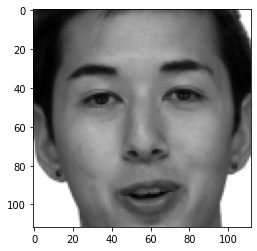

In [18]:
b = test_ds.unbatch().take(1)

for elem in b:
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(elem[0], cmap='gray')

### Load best model

In [20]:
models_list = os.listdir(models_video_path)

acc = [float(model.split('[')[1].split(']')[0]) for model in models_list]
idx = acc.index(max(acc))                                                       # index of best model

model_video = keras.models.load_model(models_video_path + models_list[idx])
model_video.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                        

## Dataset audio creation

In [58]:
filenames_test = [] # test

path = []
label = []

for dirpath, dirnames, fn in os.walk(dataset_audio_path):
    dirnames.sort()
    if fn != []:
        for elem in fn:
            class_temp = int(elem.split('-')[2]) - 1
            if class_temp != 0:
                path.append(os.path.join(dirpath, elem))
        # print(int(fn[0].split('-')[2]))
        # class_temp = int(fn[0].split('-')[2]) - 1
        # print(class_temp)
        # if class_temp != 0:  
        #     print(class_temp)                                                   # exclude 'neutral' label
    #         if any(act in dirpath for act in test_actors):                      # select only train actors
    #             path = [os.path.join(dirpath, elem) for elem in fn]
    #             label = [emotions_tras[class_temp]] * len(fn)                   # emotion trasposition
    #             filenames_test.append(list(zip(path, label)))
num_videos = len(filenames_test)
num_videos

0

In [ ]:
models_list = os.listdir(models_audio_path)

model_audio = keras.models.load_model(models_audio_path + models_list[0])
model_audio.summary()

In [ ]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
X_test = np.expand_dims(X_test, axis = 3)

## Prediction video

### Evaluate single frame

In [21]:
loss_single_frame, acc_single_frame = model_video.evaluate(test_ds, steps=step_per_epoch_test)
print('accuratezza single frame:', round(acc_single_frame, 4))

224/224 [==============================] - 6s 11ms/step - loss: 1.5807 - sparse_categorical_accuracy: 0.5277
accuratezza single frame: 0.5277


In [22]:
predic = model_video.predict(test_ds, steps=step_per_epoch_test).argmax(axis=1)
ground = [elem[0][1]  for elem in filenames_test]
ground = np.repeat(ground, frames_per_vid)

224/224 [==============================] - 2s 9ms/step


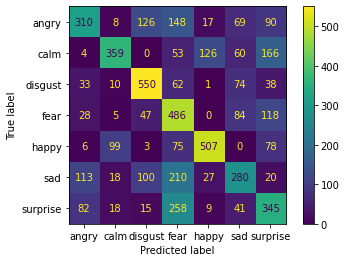

In [23]:
cm = confusion_matrix(ground, predic)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()

In [24]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

stats = pd.DataFrame({'Recall': recall, 'Precision': precision}, index=emotions.values())
round(stats, 2)

,Recall,Precision
angry,0.40,0.54
calm,0.47,0.69
disgust,0.72,0.65
fear,0.63,0.38
happy,0.66,0.74
sad,0.36,0.46
surprise,0.45,0.40


### Evaluate full video

In [25]:
pred = model_video.predict(test_ds, steps=step_per_epoch_test)

224/224 [==============================] - 2s 10ms/step


In [26]:
example_id = 0
example = np.array_split(pred, num_videos)[example_id]

print('ground truth:\t', filenames_test[example_id][0][1])

# print('predicted:\t', np.median(o, axis=0).argmax())
# print('predicted:\t', np.sum(o, axis=0).argmax())
print('predicted:\t', np.mean(example, axis=0).argmax())
np.sum(example, axis=0)

ground truth:	 1
predicted:	 1


array([1.18160285e-01, 1.47508430e+01, 2.23013922e-03, 7.26261377e-01,
       6.61967471e-02, 4.38067627e+00, 3.95563340e+00], dtype=float32)

In [27]:
pred_list = np.array_split(pred, num_videos)

ground = []
predic = []

i = 0
for count, video in enumerate(pred_list):
    predic.append(np.mean(video, axis=0).argmax())
    # predic.append(np.average(video, axis=0, weights=np.max(video, axis=1)).argmax()) # weighted mean on highest prediction value
    ground.append(filenames_test[count][0][1])
    
    if predic[count] == ground[count]:
        i += 1

print('accuracy full video:\t', round(i/len(pred_list), 4))
print('Num videos:\t\t', count+1)

accuracy full video:	 0.5938
Num videos:		 224


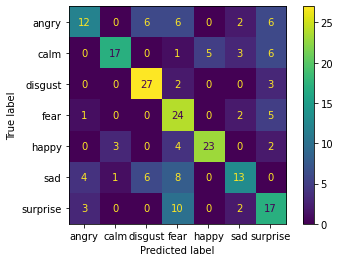

In [28]:
cm = confusion_matrix(ground, predic)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()

In [29]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

stats = pd.DataFrame({'Recall': recall, 'Precision': precision}, index=emotions.values())
round(stats, 2)

,Recall,Precision
angry,0.38,0.60
calm,0.53,0.81
disgust,0.84,0.69
fear,0.75,0.44
happy,0.72,0.82
sad,0.41,0.59
surprise,0.53,0.44


## Prediction audio